## import necessary libraries for pruning

In [2]:
import torch
import torch.nn as nn
import torch_pruning as tp
import matplotlib.pyplot as plt
from torch import optim
from torch_pruning.pruner.algorithms.scheduler import linear_scheduler
from torchsummary import summary

from cnn.resNet.resnet_example import get_data_loaders
import torch
from torch import nn

### Seed Network

In [4]:
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, expansion=6):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.use_res_connect = self.stride == 1 and in_channels == out_channels

        # Standard PyTorch layers (NO torch_pruning wrappers needed)
        self.conv1 = nn.Conv2d(in_channels, in_channels * expansion, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels * expansion)
        self.relu = nn.ReLU6(inplace=True)

        self.conv2 = nn.Conv2d(
            in_channels * expansion, in_channels * expansion, kernel_size=3,
            stride=stride, padding=1, groups=in_channels * expansion, bias=False
        )
        self.bn2 = nn.BatchNorm2d(in_channels * expansion)

        self.conv3 = nn.Conv2d(in_channels * expansion, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x if self.use_res_connect else None

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.use_res_connect:
            return identity + out
        else:
            return out

### Mask Network

In [5]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        # --- Remove mask-related parameters ---
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU6(inplace=True)

        # Define blocks (no mask_index or mask)
        self.block1 = InvertedResidual(32, 16, stride=1)
        self.block2 = InvertedResidual(16, 24, stride=2)
        self.block3 = InvertedResidual(24, 32, stride=2)
        self.block4 = InvertedResidual(32, 64, stride=2)
        self.block5 = InvertedResidual(64, 96, stride=1)
        self.block6 = InvertedResidual(96, 160, stride=2)
        self.block7 = InvertedResidual(160, 320, stride=1)

        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # --- Remove mask-based block skipping ---
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def save_model_as_onnx(model, example_input, output_path):
    # Set model to evaluation mode
    model.eval()
    # Export to ONNX
    torch.onnx.export(
        model,
        example_input,
        output_path,
        export_params=True,
        opset_version=13,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    print(f"✅ Model saved as ONNX to {output_path}")

In [8]:
def calculate_macs(model, example_input):
    macs, params = tp.utils.count_ops_and_params(model, example_input)
    return macs, params

### compare results of different pruning strategies

In [9]:
def compare_results(results):
    print("\n=== Pruning Strategy Comparison ===")
    print(f"{'Strategy':<12} | {'MACs':<12} | {'Size (MB)':<10} | {'Accuracy (%)':<12}")
    print("-" * 55)
    for strategy, metrics in results.items():
        print(f"{strategy:<12} | {metrics['macs']:.2e} | {metrics['size_mb']:>9.2f} | {metrics['accuracy']:>12.2f}")

### compare and plot results

In [10]:
import matplotlib.pyplot as plt
def compare_results_and_plot(results, output_dir='output'):
    """
    Print a comparison table and generate bar charts for MACs, model size, and accuracy
    for each pruning strategy, including the initial model.
    """
    # Print comparison table
    print("\n=== Pruning Strategy Comparison ===")
    print(f"{'Strategy':<12} | {'MACs':<12} | {'Size (MB)':<10} | {'Accuracy (%)':<12}")
    print("-" * 55)
    for strategy, metrics in results.items():
        print(f"{strategy:<12} | {metrics['macs']:.2e} | {metrics['size_mb']:>9.2f} | {metrics['accuracy']:>12.2f}")

    # Generate bar charts
    os.makedirs(output_dir, exist_ok=True)
    strategies = ['initial'] + [s for s in results if s != 'initial']
    metrics = ['macs', 'size_mb', 'accuracy']
    titles = {
        'macs': 'MACs Comparison',
        'size_mb': 'Model Size (MB) Comparison',
        'accuracy': 'Accuracy (%) Comparison'
    }
    y_labels = {
        'macs': 'MACs (Millions)',
        'size_mb': 'Size (MB)',
        'accuracy': 'Accuracy (%)'
    }

    colors = plt.cm.tab10(range(len(strategies)))
    for metric in metrics:
        values = [results[strategy][metric] / 1e6 if metric == 'macs' else results[strategy][metric]
                  for strategy in strategies]  # Convert MACs to millions
        plt.figure(figsize=(12, 6))
        bars = plt.bar(strategies, values, color=colors)
        plt.xlabel('Strategy')
        plt.ylabel(y_labels[metric])
        plt.title(titles[metric])
        plt.xticks(rotation=45, ha='right')

        # Add value labels
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., yval, f'{yval:.2f}', ha='center', va='bottom')

        # Add initial model reference line
        initial_value = results['initial'][metric] / 1e6 if metric == 'macs' else results['initial'][metric]
        plt.axhline(y=initial_value, color='r', linestyle='--', label='Initial')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{metric}_comparison.png'))
        plt.close()

### Load Model

In [11]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

### Utility function to save the model

In [13]:
import os

def save_model(model, path, example_input=None):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    if example_input is not None:
        onnx_path = path.replace('.pth', '.onnx')
        save_model_as_onnx(model, example_input, onnx_path)

### Evaluate the model

In [14]:
def evaluate_model(model, test_loader, example_input, device):
    model.eval()
    # Calculate metrics
    macs, _ = calculate_macs(model, example_input)
    params = sum(p.numel() for p in model.parameters())
    size_mb = params * 4 / 1e6

    # Calculate accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = [d.to(device) for d in data]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return {
        'macs': macs,
        'size_mb': size_mb,
        'accuracy': 100 * correct / total
    }

### Prune the model

In [15]:
def prune_model(model, example_input, target_macs, strategy, iterative_steps=5):
    #, iterative_pruning_ratio_scheduler=linear_scheduler()):
    if isinstance(strategy['importance'], tp.importance.TaylorImportance):
        pruning_ratio = 0.1
    else:
        pruning_ratio = 0.5

    pruner = strategy['pruner'](
        model,
        example_input,
        importance=strategy['importance'],
        iterative_steps=iterative_steps,
        ch_sparsity=pruning_ratio,  # Initial sparsity
        #iterative_pruning_ratio_scheduler=iterative_pruning_ratio_scheduler,
        root_module_types=[nn.Conv2d],
        ignored_layers=[model.fc],
    )

    current_macs, base_nparams = calculate_macs(model, example_input)
    # while current_macs > target_macs:
    #     pruner.step()
    #     current_macs = calculate_macs(model, example_input)


    for i in range(iterative_steps):
            if isinstance(strategy['importance'], tp.importance.TaylorImportance):
                loss = model(example_input).sum() # a dummy loss for TaylorImportance
                loss.backward()
            for g in pruner.step(interactive=True):
                g.prune()
            macs, nparams = tp.utils.count_ops_and_params(model, example_input)
            #print(model(example_input).shape)
            print(
                "  Iter %d/%d, Params: %.2f M => %.2f M"
                % (i + 1, iterative_steps, base_nparams / 1e6, nparams / 1e6)
            )
            print(
                "  Iter %d/%d, MACs: %.2f G => %.2f G"
                % (i + 1, iterative_steps, current_macs / 1e9, macs / 1e9)
            )

    return model

### Train the model

In [16]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for data in train_loader:
            inputs, labels = [d.to(device) for d in data]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.2f}%")
    return model

### Main workflow

In [17]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Configuration
    config = {
        'strategies': {
            'magnitude': {
                'pruner': tp.pruner.MagnitudePruner,
                'importance': tp.importance.MagnitudeImportance(p=2),
            },
            'bn_scale': {
                'pruner': tp.pruner.BNScalePruner,
                'importance': tp.importance.BNScaleImportance(),
            },
            # todo: check the examples for the following strategies, why it is giving error
            'group_norm': {
                'pruner': tp.pruner.GroupNormPruner,
                'importance': tp.importance.GroupMagnitudeImportance(p=1),
            },
            'random': {
                'pruner': tp.pruner.MagnitudePruner,
                'importance': tp.importance.RandomImportance(),
            },
            'Taylor': {
                'pruner': tp.pruner.MagnitudePruner,
                'importance': tp.importance.TaylorImportance()
            },
            'Hessian': {
                'pruner': tp.pruner.MagnitudePruner,
                'importance': tp.importance.GroupHessianImportance()
            },
            'lamp': {
                'pruner': tp.pruner.MagnitudePruner,
                'importance': tp.importance.LAMPImportance(p=2)
            },
            'geometry': {
                'pruner': tp.pruner.MagnitudePruner,
                'importance': tp.importance.FPGMImportance()
            },
            #todo: implement growing reg pruning
        },
        #todo: different types of schedulers can be added
        #'iterative_pruning_ratio_scheduler': linear_scheduler(),
        'target_macs_sparsity': 0.5,
        'train_epochs': 10,
        'fine_tune_epochs': 20,
        'data_dir': './data',
        'output_dir': './output/strategies',
        'iterative_steps': 5,
    }

    # Initialize model and data
    model = MobileNetV2(num_classes=10).to(device)
    train_loader, test_loader = get_data_loaders(config['data_dir'])
    example_input = torch.randn(1, 3, 32, 32).to(device) #fixed input

    # Workflow execution
    initial_model_path = os.path.join(config['output_dir'], "mobilenetv2_initial.pth")

    if not os.path.exists(initial_model_path):
        # 1. Initial training
        model = train_model(
            model=model,
            train_loader=train_loader,
            criterion=nn.CrossEntropyLoss().to(device),
            optimizer=optim.Adam(model.parameters(), lr=0.001),
            device=device,
            num_epochs=config['train_epochs']
        )
        save_model(model, initial_model_path, example_input)

    # 2. Pruning and evaluation workflow
    results = {}
    initial_metrics = evaluate_model(model, test_loader, example_input, device)
    results['initial'] = initial_metrics

    # Pruning and evaluation workflow
    initial_macs, initial_params = calculate_macs(model, example_input)
    target_macs = initial_macs * config['target_macs_sparsity']
    print(f"initial value: target_macs={target_macs:.2f}")
    for strategy_name in config['strategies']:
        # 2a. Prepare fresh model for each strategy
        model_copy = load_model(MobileNetV2(num_classes=10).to(device), initial_model_path)

        # 2b. Perform pruning
        """ this it normal pruning without threshold
        pruned_model = prune_model(
            model=model_copy,
            example_input=example_input,
            target_macs=target_macs,
            strategy=config['strategies'][strategy_name],
            iterative_steps=config['iterative_steps'],
            #iterative_pruning_ratio_scheduler=config['iterative_pruning_ratio_scheduler'],
        ) """

        pruned_model = gr_prune_model_with_threshold(
            model=model_copy,
            example_input=example_input,
            target_macs=1e9,
            target_size_mb=5,
            strategy=config['strategies'][strategy_name],
            iterative_steps=config['iterative_steps']
        )

        """
        target_macs_value = 3.0e6
        target_params_value = 5.0e6
        pruned_model = gem_prune_model_by_threshold(
            model=model_copy,
            example_input=example_input,
            target_macs=target_macs_value,     # <-- Pass target MACs
            target_params=target_params_value, # <-- Pass target Params
            strategy=config['strategies'][strategy_name],
            max_iterations=100, # Adjust as needed
            step_ch_sparsity=0.1 # Tune this - smaller might be safer but slower
        )
        """

        # 2c. Save pruned model
        pruned_path = os.path.join(config['output_dir'], f"mobilenetv2_{strategy_name}_pruned.pth")
        save_model(pruned_model, pruned_path, example_input)

        # 2d. Fine-tune
        # todo: lr, more epochs, early stopping
        fine_tuned_model = train_model(
            model=pruned_model,
            train_loader=train_loader,
            criterion=nn.CrossEntropyLoss().to(device),
            optimizer=optim.Adam(pruned_model.parameters(), lr=0.001),
            device=device,
            num_epochs=config['fine_tune_epochs']
        )

        # 2e. Evaluate
        results[strategy_name] = evaluate_model(
            model=fine_tuned_model,
            test_loader=test_loader,
            example_input=example_input,
            device=device
        )

        # 2f. Save final model
        final_path = os.path.join(config['output_dir'], f"mobilenetv2_{strategy_name}_final.pth")
        save_model(fine_tuned_model, final_path, example_input)

    # 3. Compare results
    compare_results_and_plot(results, output_dir=config['output_dir'])
    print("Workflow completed successfully!")

In [18]:
if __name__ == "__main__":
    main()

Using dataset directory: /home/muis/thesis/github-repo/master-thesis/cnn/mobile_net_v2/data
Epoch 1/10: Loss=1.6614, Accuracy=39.16%
Epoch 2/10: Loss=1.3093, Accuracy=53.03%
Epoch 3/10: Loss=1.1322, Accuracy=59.75%
Epoch 4/10: Loss=0.9907, Accuracy=65.03%
Epoch 5/10: Loss=0.8971, Accuracy=68.39%
Epoch 6/10: Loss=0.8192, Accuracy=71.20%
Epoch 7/10: Loss=0.7558, Accuracy=73.63%
Epoch 8/10: Loss=0.7031, Accuracy=75.17%
Epoch 9/10: Loss=0.6546, Accuracy=77.06%
Epoch 10/10: Loss=0.6158, Accuracy=78.24%
✅ Model saved as ONNX to ./output/strategies/mobilenetv2_initial.onnx
initial value: target_macs=3029893.00
--- Starting Pruning (Strategy: MagnitudeImportance) ---
Target MACs: 3,000,000, Target Params: 5,000,000
Initial | MACs: 6,059,786, Params: 1,169,642
Iter   1/100 | MACs: 6,059,786 -> 4,924,394 (+18.7%) | Params: 1,169,642 -> 950,314 (+18.8%)
Iteration 2: Pruner found no more candidates. Stopping.
--- Finished Pruning (Strategy: MagnitudeImportance) ---
Initial | MACs: 6,059,786, Param

/home/muis/.virtualenvs/master-thesis/lib/python3.12/site-packages/torch_pruning/pruner/algorithms/base_pruner.py:87: UserWarning: ch_sparsity is deprecated in v1.3.0. Please use pruning_ratio.
  warnings.warn(
/home/muis/.virtualenvs/master-thesis/lib/python3.12/site-packages/torch_pruning/pruner/algorithms/base_pruner.py:407: UserWarning: Pruning exceed the maximum iterative steps, no pruning will be performed.
  warnings.warn(


✅ Model saved as ONNX to ./output/strategies/mobilenetv2_magnitude_pruned.onnx
Epoch 1/20: Loss=0.6750, Accuracy=76.34%
Epoch 2/20: Loss=0.6054, Accuracy=78.79%
Epoch 3/20: Loss=0.5644, Accuracy=80.39%
Epoch 4/20: Loss=0.5401, Accuracy=80.95%
Epoch 5/20: Loss=0.5067, Accuracy=82.10%
Epoch 6/20: Loss=0.4807, Accuracy=83.06%
Epoch 7/20: Loss=0.4550, Accuracy=84.01%
Epoch 8/20: Loss=0.4325, Accuracy=84.81%
Epoch 9/20: Loss=0.4146, Accuracy=85.24%
Epoch 10/20: Loss=0.3927, Accuracy=86.04%
Epoch 11/20: Loss=0.3773, Accuracy=86.65%
Epoch 12/20: Loss=0.3663, Accuracy=86.93%
Epoch 13/20: Loss=0.3462, Accuracy=87.70%
Epoch 14/20: Loss=0.3234, Accuracy=88.44%
Epoch 15/20: Loss=0.3160, Accuracy=88.74%
Epoch 16/20: Loss=0.2987, Accuracy=89.34%
Epoch 17/20: Loss=0.2916, Accuracy=89.60%
Epoch 18/20: Loss=0.2796, Accuracy=89.94%
Epoch 19/20: Loss=0.2654, Accuracy=90.63%
Epoch 20/20: Loss=0.2586, Accuracy=90.67%
✅ Model saved as ONNX to ./output/strategies/mobilenetv2_magnitude_final.onnx
--- Starting

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 576, 1, 1])

### Load the saved Onnx model and convert to Pytorch model

In [12]:
import torch
import onnx
import onnxruntime
from onnx2torch import convert

# Step 1: Load the ONNX model
onnx_model_path = './output/strategies/mobilenetv2_bn_scale_final.onnx'
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)  # Verify the ONNX model
print("✅ ONNX model loaded and verified.")

# Step 2: Convert ONNX to PyTorch
torch_model = convert(onnx_model)
print("✅ ONNX model converted to PyTorch.")
tp.utils.print_tool.before_pruning(torch_model)


✅ ONNX model loaded and verified.
✅ ONNX model converted to PyTorch.


In [13]:
from torchinfo import summary
print(summary(torch_model))

Layer (type:depth-idx)                                  Param #
GraphModule                                             --
├─Conv2d: 1-1                                           448
├─OnnxConstant: 1-2                                     --
├─OnnxConstant: 1-3                                     --
├─ReLU6: 1-4                                            --
├─Conv2d: 1-5                                           1,632
├─OnnxConstant: 1-6                                     --
├─OnnxConstant: 1-7                                     --
├─ReLU6: 1-8                                            --
├─Conv2d: 1-9                                           960
├─OnnxConstant: 1-10                                    --
├─OnnxConstant: 1-11                                    --
├─ReLU6: 1-12                                           --
├─Conv2d: 1-13                                          776
├─Conv2d: 1-14                                          432
├─OnnxConstant: 1-15                        

In [11]:

from torchinfo import summary
print(summary(torch_model))
#tp.utils.print_tool.after_pruning(torch_model)


Layer (type:depth-idx)                                  Param #
GraphModule                                             --
├─Conv2d: 1-1                                           896
├─OnnxConstant: 1-2                                     --
├─OnnxConstant: 1-3                                     --
├─ReLU6: 1-4                                            --
├─Conv2d: 1-5                                           6,336
├─OnnxConstant: 1-6                                     --
├─OnnxConstant: 1-7                                     --
├─ReLU6: 1-8                                            --
├─Conv2d: 1-9                                           1,920
├─OnnxConstant: 1-10                                    --
├─OnnxConstant: 1-11                                    --
├─ReLU6: 1-12                                           --
├─Conv2d: 1-13                                          3,088
├─Conv2d: 1-14                                          1,632
├─OnnxConstant: 1-15                  

### Load the converted Pytorch model and fine-tune

In [6]:
train_loader, test_loader = get_data_loaders('./data')
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch_model = torch_model.to(device)

tp.utils.print_tool.before_pruning(torch_model)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001)
num_epochs = 50

fine_tuned_model = train_model(torch_model, train_loader, criterion, optimizer, device, num_epochs)

Using dataset directory: /home/muis/thesis/github-repo/master-thesis/cnn/mobile_net_v2/data
Epoch 1/50: Loss=0.6039, Accuracy=78.76%
Epoch 2/50: Loss=0.6009, Accuracy=78.70%
Epoch 3/50: Loss=0.5960, Accuracy=78.91%
Epoch 4/50: Loss=0.5975, Accuracy=78.81%
Epoch 5/50: Loss=0.5957, Accuracy=78.92%
Epoch 6/50: Loss=0.5969, Accuracy=78.82%
Epoch 7/50: Loss=0.6109, Accuracy=78.42%
Epoch 8/50: Loss=0.6080, Accuracy=78.65%
Epoch 9/50: Loss=0.6081, Accuracy=78.52%
Epoch 10/50: Loss=0.6090, Accuracy=78.53%
Epoch 11/50: Loss=0.6294, Accuracy=77.73%
Epoch 12/50: Loss=0.6354, Accuracy=77.75%
Epoch 13/50: Loss=0.6369, Accuracy=77.76%
Epoch 14/50: Loss=0.6398, Accuracy=77.80%
Epoch 15/50: Loss=0.6449, Accuracy=77.49%
Epoch 16/50: Loss=0.6451, Accuracy=77.21%
Epoch 17/50: Loss=0.6569, Accuracy=76.93%
Epoch 18/50: Loss=0.6594, Accuracy=76.96%
Epoch 19/50: Loss=0.6644, Accuracy=76.68%
Epoch 20/50: Loss=0.6890, Accuracy=76.04%
Epoch 21/50: Loss=0.7159, Accuracy=75.11%
Epoch 22/50: Loss=0.7258, Accuracy=

### Plotting params results

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Total parameters for each model
strategies = ['Initial', 'Magnitude', 'BN Scale', 'Group Norm', 'Random', 'Taylor', 'Hessian', 'Lamp']
params = [
    1162530,  # Initial model (from your query)
    305350,   # Magnitude (from output: 0.31M after pruning, assuming final tuned model)
    301558,   # BN Scale (from your query and output: 0.31M after pruning)
    305350,   # Group Norm (from output: 0.31M after pruning, assuming similar to magnitude)
    305350,   # Random (from output: 0.31M after pruning, assuming similar to magnitude)
    949650,   # Taylor (from output: 0.95M after pruning)
    1162530,  # Hessian (from output: 1.17M, no reduction observed)
    305350    # Lamp (from output: 0.31M after pruning)
]
initial_params = params[0]

# Calculate percentage reduction for each strategy
reductions = [((initial_params - p) / initial_params * 100) for p in params]

# Colors for each strategy
colors = ['gray', 'blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

# Create bar chart
plt.figure(figsize=(14, 8))
bars = plt.bar(strategies, params, color=colors)

# Add value labels and percentage reduction
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}\n({reductions[i]:.1f}%)' if i > 0 else f'{height:,}',
             ha='center', va='bottom', fontsize=9)

# Add horizontal line for initial parameters
plt.axhline(y=initial_params, color='gray', linestyle='--', label='Initial Parameters')

# Customize the chart
plt.xlabel('Pruning Strategy')
plt.ylabel('Total Parameters')
plt.title('Comparison of Total Parameters Across Pruning Strategies')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Save the chart to a file (since we're not displaying it interactively)
plt.savefig('output/pruning_comparison.png')

### comparison for MACs, params, size_mb

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Metrics for each model
strategies = ['Initial', 'Magnitude', 'BN Scale', 'Group Norm', 'Random', 'Taylor', 'Hessian', 'Lamp']
metrics = {
    'params': [1162530, 305350, 301558, 305350, 305350, 949650, 1162530, 305350],  # Total parameters
    'macs': [6060000, 1840000, 1840000, 1840000, 1840000, 4920000, 6060000, 1840000],  # MACs
    'size_mb': [4.68, 1.22, 1.22, 1.22, 1.22, 3.80, 4.68, 1.22]  # Model size in MB
}
initial_metrics = {k: v[0] for k, v in metrics.items()}

# Calculate percentage reductions
reductions = {k: [((initial_metrics[k] - v) / initial_metrics[k] * 100) for v in values] for k, values in metrics.items()}

# Colors for each strategy
colors = ['gray', 'blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Plot each metric
for i, (metric_name, values) in enumerate(metrics.items()):
    ax = axes[i]
    bars = ax.bar(strategies, values, color=colors)

    # Add value labels and percentage reduction
    for j, bar in enumerate(bars):
        height = bar.get_height()
        label = f'{height:,}' if metric_name != 'size_mb' else f'{height:.2f}'
        if j > 0:
            label += f'\n({reductions[metric_name][j]:.1f}%)'
        ax.text(bar.get_x() + bar.get_width()/2., height, label, ha='center', va='bottom', fontsize=9)

    # Add horizontal line for initial metric
    ax.axhline(y=initial_metrics[metric_name], color='gray', linestyle='--', label='Initial')

    # Customize subplot
    ax.set_xlabel('Pruning Strategy')
    ax.set_ylabel(metric_name.replace('_', ' ').title())
    ax.set_title(f'Comparison of {metric_name.replace("_", " ").title()} Across Pruning Strategies')
    ax.set_xticks(range(len(strategies)))
    ax.set_xticklabels(strategies, rotation=45, ha='right')
    ax.legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig('output/pruning_metrics_comparison.png')

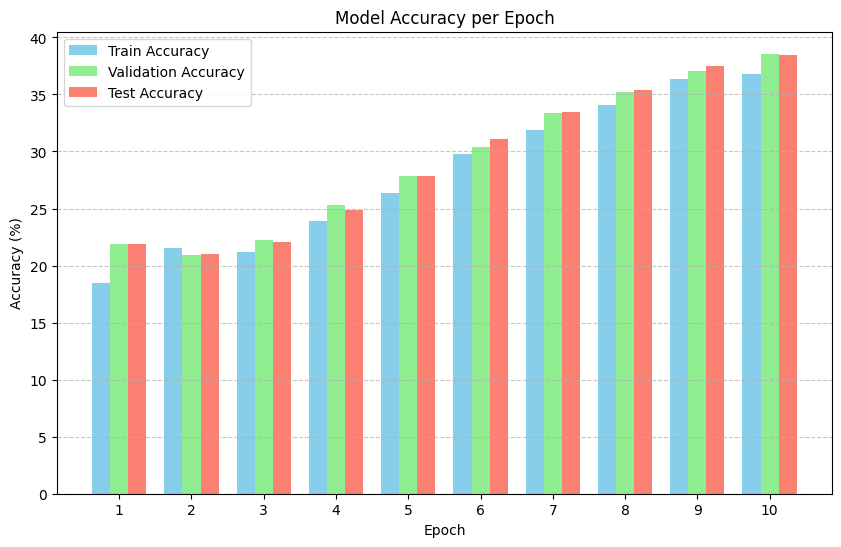

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
epochs = list(range(1, 11))
train_acc = [18.48, 21.53, 21.21, 23.94, 26.32, 29.75, 31.91, 34.05, 36.34, 36.77]
valid_acc = [21.93, 20.94, 22.23, 25.33, 27.88, 30.41, 33.33, 35.23, 37.02, 38.57]
test_acc = [21.90, 21.01, 22.10, 24.86, 27.84, 31.08, 33.47, 35.38, 37.53, 38.45]

# Set up the plot
plt.figure(figsize=(10, 6))
bar_width = 0.25
x = np.arange(len(epochs))

# Create bars
plt.bar(x - bar_width, train_acc, bar_width, label='Train Accuracy', color='skyblue')
plt.bar(x, valid_acc, bar_width, label='Validation Accuracy', color='lightgreen')
plt.bar(x + bar_width, test_acc, bar_width, label='Test Accuracy', color='salmon')

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy per Epoch')
plt.xticks(x, epochs)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Save the plot
plt.savefig('darts_accuracy_bar_plot.png')

### Gr: prune with threshold

In [15]:
#def gr_prune_model_with_threshold(model, example_input, target_macs, target_size_mb, strategy, max_iterative_steps=20, max_sparsity=0.9):
def gr_prune_model_with_threshold(model, example_input, target_macs, target_size_mb, strategy, iterative_steps=5):
    """
    Prune the model based on the specified strategy and targets.
    """
    # Calculate initial metrics
    current_macs, nparams = tp.utils.count_ops_and_params(model, example_input)
    current_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 ** 2)

    print(f"Initial MACs: {current_macs / 1e9:.3f} G, Size: {current_size_mb:.2f} MB")

    # Define pruning ratio (adjust based on targets if needed)
    pruning_ratio = 0.5  # Example: 50% sparsity, adjust as needed

    if isinstance(strategy['importance'], tp.importance.TaylorImportance):
        # TaylorImportance requires gradients per step
        pruner = strategy['pruner'](
            model,
            example_input,
            importance=strategy['importance'],
            iterative_steps=1,  # Handle iterations manually
            ch_sparsity=pruning_ratio / iterative_steps,  # Prune a portion each step
            root_module_types=[nn.Conv2d],
            ignored_layers=[model.fc]
        )
        for i in range(iterative_steps):
            model.zero_grad()
            loss = model(example_input).sum()  # Dummy loss for gradients
            loss.backward()
            pruner.step()  # Apply pruning for this step
            current_macs, _ = tp.utils.count_ops_and_params(model, example_input)
            current_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 ** 2)
            print(f"Step {i+1}/{iterative_steps}: MACs {current_macs / 1e9:.3f} G, Size {current_size_mb:.2f} MB")
            if current_macs <= target_macs and current_size_mb <= target_size_mb:
                print(f"Targets reached at step {i+1}")
                break
            model.zero_grad()
    else:
        # Other strategies can prune in one go with iterative_steps
        pruner = strategy['pruner'](
            model,
            example_input,
            importance=strategy['importance'],
            iterative_steps=iterative_steps,
            ch_sparsity=pruning_ratio,
            root_module_types=[nn.Conv2d],
            ignored_layers=[model.fc]
        )
        pruner.step()  # Perform pruning over all steps
        current_macs, _ = tp.utils.count_ops_and_params(model, example_input)
        current_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 ** 2)
        print(f"After pruning: MACs {current_macs / 1e9:.3f} G, Size {current_size_mb:.2f} MB")

    # Final check
    if current_macs <= target_macs and current_size_mb <= target_size_mb:
        print("Pruning targets achieved.")
    else:
        print("Warning: Pruning targets not fully achieved.")

    return model

### Gem: Prune with threshold

In [1]:
import time # Optional: for adding time limits or tracking

# Assume calculate_macs is defined as before:
# def calculate_macs(model, example_input):
#     macs, params = tp.utils.count_ops_and_params(model, example_input)
#     return macs, params

def gem_prune_model_by_threshold(model, example_input, target_macs, target_params, strategy, max_iterations=100, step_ch_sparsity=0.1):
    """
    Prunes the model iteratively until both MACs and parameter count are below
    the specified thresholds, or max_iterations is reached.

    Args:
        model: The PyTorch model to prune.
        example_input: Example input tensor for MACs calculation and pruner.
        target_macs: The desired maximum MAC count.
        target_params: The desired maximum parameter count.
        strategy: Dictionary containing 'pruner' and 'importance'.
        max_iterations (int): Safety limit for the number of pruning steps.
        step_ch_sparsity (float): Channel sparsity target for each individual pruning step.
                                  Influences how many candidates `pruner.step` proposes.
                                  Smaller values lead to potentially finer steps.

    Returns:
        The pruned model.
    """
    device = example_input.device
    model.to(device) # Ensure model is on the correct device

    print(f"--- Starting Pruning (Strategy: {strategy['importance'].__class__.__name__}) ---")
    print(f"Target MACs: {target_macs:,.0f}, Target Params: {target_params:,.0f}")

    # Instantiate the pruner
    # Note: 'iterative_steps' in init is less critical here as the while loop controls iteration.
    pruner = strategy['pruner'](
        model,
        example_input,
        importance=strategy['importance'],
        ch_sparsity=step_ch_sparsity, # Target sparsity *per step*
        root_module_types=[nn.Conv2d], # Focus pruning on Conv layers
        ignored_layers=[model.fc], # Don't prune the final classifier
        # Optional: other pruner args like round_to might be useful depending on strategy/model
        # round_to=8, # Example: commonly used for hardware efficiency
    )

    # Get initial state
    current_macs, current_params = calculate_macs(model, example_input)
    initial_macs, initial_params = current_macs, current_params # Keep for logging
    print(f"Initial | MACs: {current_macs:,.0f}, Params: {current_params:,.0f}")

    iteration = 0
    model.eval() # Ensure model is in eval mode for pruning logic unless Taylor

    while (current_macs > target_macs or current_params > target_params) and iteration < max_iterations:
        iteration += 1
        macs_before_step = current_macs
        params_before_step = current_params

        # --- Special handling for Importance methods requiring gradients ---
        if isinstance(strategy['importance'], (tp.importance.TaylorImportance, tp.importance.GroupHessianImportance)):
             model.train() # Need gradients
             # Ensure requires_grad is True if it was turned off
             for param in model.parameters():
                 param.requires_grad_(True)

             loss = model(example_input).mean() # Use mean or sum as dummy loss
             try:
                 loss.backward() # Calculate gradients needed for importance
             except Exception as e:
                 print(f"Error during backward pass for importance calc (Iter {iteration}): {e}")
                 # Decide how to handle: break, skip step, etc.
                 break # Safer to stop if backward fails

        # --- Perform one step of interactive pruning ---
        try:
            # Get the next set of pruning candidates based on current importance
            pruning_groups = list(pruner.step(interactive=True))
        except Exception as e:
             print(f"Error during pruner.step() (Iter {iteration}): {e}")
             # Handle potential errors during dependency analysis or importance scoring
             break # Stop if pruner step fails

        if not pruning_groups:
            print(f"Iteration {iteration}: Pruner found no more candidates. Stopping.")
            break # No more structures can be pruned according to the strategy/dependencies

        # --- Apply the pruning ---
        for group in pruning_groups:
            group.prune()

        # --- Clean up gradients if calculated ---
        if isinstance(strategy['importance'], (tp.importance.TaylorImportance, tp.importance.GroupHessianImportance)):
            # Zero gradients to prevent interference with potential future training/fine-tuning
            model.zero_grad()
            model.eval() # Switch back to eval mode after grad calculation

        # --- Recalculate metrics ---
        # It's crucial to recalculate AFTER pruning is applied
        current_macs, current_params = calculate_macs(model, example_input)

        # --- Log progress ---
        print(
            f"Iter {iteration: >3}/{max_iterations} | "
            f"MACs: {macs_before_step:,.0f} -> {current_macs:,.0f} "
            f"({(macs_before_step-current_macs)/macs_before_step*100:+.1f}%) | "
            f"Params: {params_before_step:,.0f} -> {current_params:,.0f} "
            f"({(params_before_step-current_params)/params_before_step*100:+.1f}%)"
        )

        # --- Check for Stagnation (optional but recommended) ---
        if current_macs >= macs_before_step and current_params >= params_before_step:
            print(f"Iteration {iteration}: No reduction in MACs or Params this step. Stopping to prevent loop.")
            # This might happen if the only prunable groups left have negligible impact
            # or if there's an issue with the importance/pruning logic.
            break

    # --- Final Status Report ---
    print(f"--- Finished Pruning (Strategy: {strategy['importance'].__class__.__name__}) ---")
    if iteration >= max_iterations:
        print(f"Warning: Reached maximum pruning iterations ({max_iterations}).")

    final_macs, final_params = calculate_macs(model, example_input)
    print(f"Initial | MACs: {initial_macs:,.0f}, Params: {initial_params:,.0f}")
    print(f"Final   | MACs: {final_macs:,.0f}, Params: {final_params:,.0f}")
    print(f"Target  | MACs: {target_macs:,.0f}, Params: {target_params:,.0f}")

    macs_reduction = (initial_macs - final_macs) / initial_macs * 100 if initial_macs > 0 else 0
    params_reduction = (initial_params - final_params) / initial_params * 100 if initial_params > 0 else 0
    print(f"Reduction | MACs: {macs_reduction:.2f}%, Params: {params_reduction:.2f}%")

    if final_macs > target_macs or final_params > target_params:
         print("Warning: Pruning finished, but target threshold(s) were not fully met.")

    model.eval() # Ensure model is in eval mode finally
    return model